In [369]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import NMF
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score, make_scorer
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.decomposition import PCA
import datetime
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

In [370]:
df = pd.read_excel(io='Car Claim Datasets/carclaimtxt.xlsx')

In [371]:
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [357]:
report = ProfileReport(df)
report.to_html()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

'<!doctype html><html lang=en><head><meta charset=utf-8><meta name=viewport content="width=device-width, initial-scale=1, shrink-to-fit=no"><meta name=description content="Profile report generated by YData! Visit us at https://ydata.ai"><meta name=author content="YData and the open source community."><meta name=generator content="Pandas Profiling vv4.6.3"><meta name=url content=https://github.com/ydataai/ydata-profiling><meta name=date content="2023-12-31 12:13:22.156283"><title>Pandas Profiling Report</title><style>\n/*!\n * Bootstrap v3.3.7 (http://getbootstrap.com)\n * Copyright 2011-2016 Twitter, Inc.\n * Licensed under MIT (https://github.com/twbs/bootstrap/blob/master/LICENSE)\n *//*! normalize.css v3.0.3 | MIT License | github.com/necolas/normalize.css */html{font-family:sans-serif;-webkit-text-size-adjust:100%;-ms-text-size-adjust:100%}body{margin:0}article,aside,details,figcaption,figure,footer,header,hgroup,main,menu,nav,section,summary{display:block}audio,canvas,progress,vid

## EDA

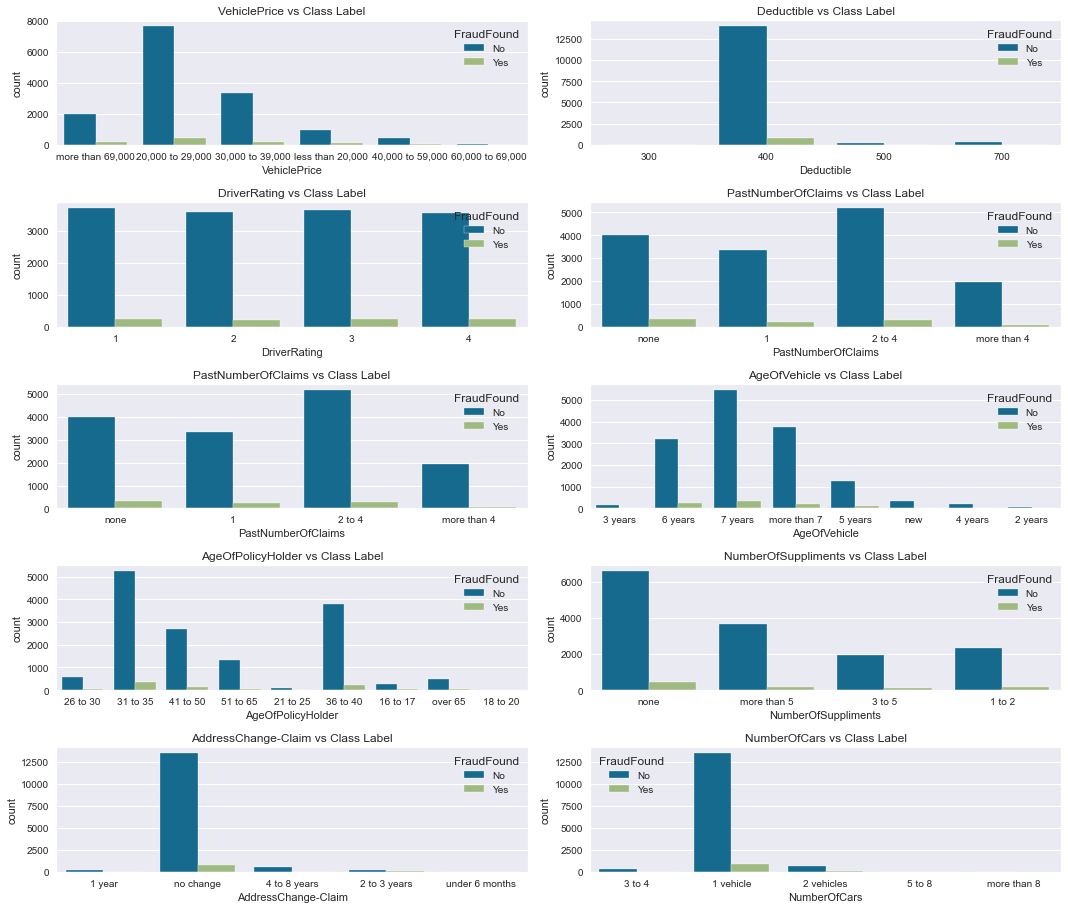

In [372]:
features = ['VehiclePrice', 'Deductible', 'DriverRating', 'PastNumberOfClaims',
            'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'NumberOfSuppliments', 
            'AddressChange-Claim', 'NumberOfCars']

class_labels = df['FraudFound']

num_rows = (len(features) + 1) // 2
num_cols = 2  # Number of subplots per row
plt.figure(figsize=(15,25))
for i, feature in enumerate(features):
    plt.subplot(len(features), 2, i+1)
    sns.countplot(data=df, x=feature, hue='FraudFound')
    plt.tight_layout()
    plt.title(f'{feature} vs Class Label')

## Feature ENgineering

In [373]:
df = df.dropna()

In [374]:
df = df[df['Age']!= 0]

### Date Features

In [375]:
month_dict = {'Jan': 1,'Feb': 2,'Mar': 3,'Apr': 4,'May': 5,
              'Jun': 6,'Jul': 7,'Aug': 8,'Sep': 9,'Oct': 10,'Nov': 11,'Dec': 12
}

df['Month'] = df['Month'].map(month_dict)
df['MonthClaimed'] = df['MonthClaimed'].map(month_dict)

In [376]:
weekday_dict = {
    'Monday': 1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4,
    'Friday':5, 'Saturday':6,'Sunday':7
}

df['DayOfWeek'] = df['DayOfWeek'].map(weekday_dict)
df['DayOfWeekClaimed'] = df['DayOfWeekClaimed'].map(weekday_dict)

In [377]:
def create_date(month,week_of_month, day_of_week, year):
    # print(month,week_of_month, day_of_week, year)
    first_day = datetime.date(year, month, 1)
    first_day_weekday = first_day.isoweekday()

    offset = day_of_week - first_day_weekday

    days_to_add = (week_of_month - 1) * 7 + offset

    date = first_day + datetime.timedelta(days=days_to_add)

    return date

In [378]:
df['date'] = df.apply(lambda x: create_date(x.Month, x.WeekOfMonth, x.DayOfWeek, x.Year), axis =1)

In [379]:
df['date_claimed'] = df.apply(lambda x: create_date(int(x.MonthClaimed), int(x.WeekOfMonthClaimed), int(x.DayOfWeekClaimed), int(x.Year)), axis =1)

In [380]:
df.loc[:, 'date'] = pd.to_datetime(df.loc[:, 'date'])
df.loc[:, 'date_claimed'] = pd.to_datetime(df.loc[:, 'date_claimed'])

In [381]:
df['date_diff'] = np.abs(df['date_claimed'] - df['date']).dt.days

In [382]:
df['date_diff']

0        365
1          5
2         13
3         20
4         15
        ... 
15415      4
15416      1
15417      1
15418     10
15419      8
Name: date_diff, Length: 15100, dtype: int64

### Encoding

In [383]:
df['Make'] = OrdinalEncoder().fit_transform(np.array(df['Make']).reshape(-1,1))
df['AccidentArea'] = OrdinalEncoder().fit_transform(np.array(df['AccidentArea']).reshape(-1,1))
df['Fault'] = OrdinalEncoder().fit_transform(np.array(df['Fault']).reshape(-1,1))
df['FraudFound'] = OrdinalEncoder().fit_transform(np.array(df['FraudFound']).reshape(-1,1))
df['PoliceReportFiled'] = OrdinalEncoder().fit_transform(np.array(df['PoliceReportFiled']).reshape(-1,1))
df['WitnessPresent'] = OrdinalEncoder().fit_transform(np.array(df['WitnessPresent']).reshape(-1,1))
df['AgentType'] = OrdinalEncoder().fit_transform(np.array(df['AgentType']).reshape(-1,1))
df['BasePolicy'] = OrdinalEncoder().fit_transform(np.array(df['BasePolicy']).reshape(-1,1))

In [384]:
df['VehiclePrice'] = OrdinalEncoder(categories=[['less than 20,000', '20,000 to 29,000', '30,000 to 39,000',
                                                '40,000 to 59,000', '60,000 to 69,000', 'more than 69,000']])\
                                    .fit_transform(np.array(df['VehiclePrice']).reshape(-1,1))

df['Deductible'] = OrdinalEncoder(categories=[['300', '400', '500', '700']])\
                                    .fit_transform(np.array(df['Deductible']).reshape(-1,1))

df['DriverRating'] = OrdinalEncoder(categories=[['1', '2', '3', '4']])\
                                    .fit_transform(np.array(df['DriverRating']).reshape(-1,1))

df[['Days:Policy-Accident']] = OrdinalEncoder(categories=[['none', '1 to 7', '8 to 15', '15 to 30', 'more than 30']])\
                                .fit_transform(df[['Days:Policy-Accident']])

df['Days:Policy-Claim'] = OrdinalEncoder(categories=[['none', '1 to 7', '8 to 15', '15 to 30', 'more than 30']])\
                                    .fit_transform(np.array(df['Days:Policy-Claim']).reshape(-1,1))

df['PastNumberOfClaims'] = OrdinalEncoder(categories=[['none', '1', '2 to 4', 'more than 4']])\
                                    .fit_transform(np.array(df['PastNumberOfClaims']).reshape(-1,1))

df['AgeOfVehicle'] = OrdinalEncoder(categories=[['new', '2 years', '3 years', '4 years',
                                                '5 years', '6 years', '7 years', 'more than 7']])\
                                    .fit_transform(np.array(df['AgeOfVehicle']).reshape(-1,1))

df['AgeOfPolicyHolder'] = OrdinalEncoder(categories=[['16 to 17','18 to 20', '21 to 25', '26 to 30', '31 to 35',
                                                      '36 to 40', '41 to 50', '51 to 65', 'over 65']])\
                                    .fit_transform(np.array(df['AgeOfPolicyHolder']).reshape(-1,1))

df['NumberOfSuppliments'] = OrdinalEncoder(categories=[['none', '1 to 2', '3 to 5', 'more than 5']])\
                                    .fit_transform(np.array(df['NumberOfSuppliments']).reshape(-1,1))

df['AddressChange-Claim'] = OrdinalEncoder(categories=[['no change', 'under 6 months', '1 year', '2 to 3 years',
                                                       '4 to 8 years']])\
                                    .fit_transform(np.array(df['AddressChange-Claim']).reshape(-1,1))

df['NumberOfCars'] = OrdinalEncoder(categories=[['1 vehicle', '2 vehicles', '3 to 4', '5 to 8','more than 8']])\
                                    .fit_transform(np.array(df['NumberOfCars']).reshape(-1,1))


In [385]:
df_ = pd.get_dummies( df, columns = [ 
                                       'Sex', 'MaritalStatus', 'PolicyType', 'VehicleCategory', 
                                        'AgeOfPolicyHolder', 'NumberOfSuppliments', 'AddressChange-Claim',
                                        'NumberOfCars', 'BasePolicy']) 

In [386]:
df_ = df_.drop(['Month', 'WeekOfMonth', 'DayOfWeek', 'Year', 'date',
                        'MonthClaimed', 'WeekOfMonthClaimed', 'DayOfWeekClaimed', 'date_claimed'], axis =1)

In [387]:
df_

,Make,AccidentArea,Age,Fault,VehiclePrice,FraudFound,PolicyNumber,RepNumber,Deductible,DriverRating,...,AddressChange-Claim_3.0,AddressChange-Claim_4.0,NumberOfCars_0.0,NumberOfCars_1.0,NumberOfCars_2.0,NumberOfCars_3.0,NumberOfCars_4.0,BasePolicy_0.0,BasePolicy_1.0,BasePolicy_2.0
0,6.0,1.0,21,0.0,5.0,0.0,1,12,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
1,6.0,1.0,34,0.0,5.0,0.0,2,15,1.0,3.0,...,0,0,1,0,0,0,0,0,1,0
2,6.0,1.0,47,0.0,5.0,0.0,3,7,1.0,2.0,...,0,0,1,0,0,0,0,0,1,0
3,17.0,0.0,65,1.0,1.0,0.0,4,4,1.0,1.0,...,0,0,1,0,0,0,0,0,0,1
4,6.0,1.0,27,1.0,5.0,0.0,5,3,1.0,0.0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,17.0,1.0,35,0.0,1.0,1.0,15416,5,1.0,3.0,...,0,0,1,0,0,0,0,0,1,0
15416,13.0,1.0,30,0.0,2.0,0.0,15417,11,1.0,2.0,...,0,0,0,0,1,0,0,0,0,1
15417,17.0,0.0,24,0.0,1.0,1.0,15418,4,1.0,3.0,...,0,0,1,0,0,0,0,0,1,0
15418,17.0,1.0,34,1.0,1.0,0.0,15419,6,1.0,3.0,...,0,0,1,0,0,0,0,1,0,0


### Other Features

In [256]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15100 entries, 0 to 15419
Data columns (total 70 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Month                            15100 non-null  int64         
 1   WeekOfMonth                      15100 non-null  int64         
 2   DayOfWeek                        15100 non-null  int64         
 3   Make                             15100 non-null  float64       
 4   AccidentArea                     15100 non-null  float64       
 5   DayOfWeekClaimed                 15100 non-null  int64         
 6   MonthClaimed                     15100 non-null  int64         
 7   WeekOfMonthClaimed               15100 non-null  int64         
 8   Age                              15100 non-null  int64         
 9   Fault                            15100 non-null  float64       
 10  VehiclePrice                     15100 non-null  float64  

In [388]:
min_max = MinMaxScaler()
df_normalized = min_max.fit_transform(df_.drop('FraudFound', axis =1))

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
df_embeded = tsne.fit_transform(df_normalized)

In [322]:
X_tsne_data = np.vstack((df_embeded.T, df_['FraudFound'])).T
df_tsne = pd.DataFrame(X_tsne_data, columns=['Dim1', 'Dim2', 'class'])
df_tsne.head()

,Dim1,Dim2,class
0,-18.022766,-2.204000,0.0
1,-80.314713,-32.007889,0.0
2,-80.512825,-47.334343,0.0
3,-59.035801,-17.826347,0.0
4,-76.999001,-32.045044,0.0


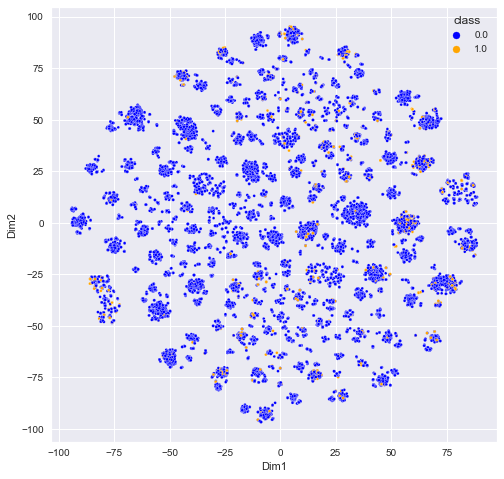

In [323]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_tsne, hue='class', x='Dim1', y='Dim2', 
                palette=['blue', 'orange'], s=8, hue_order=[0.0, 1.0])
plt.show()

## Model

### Kmeans

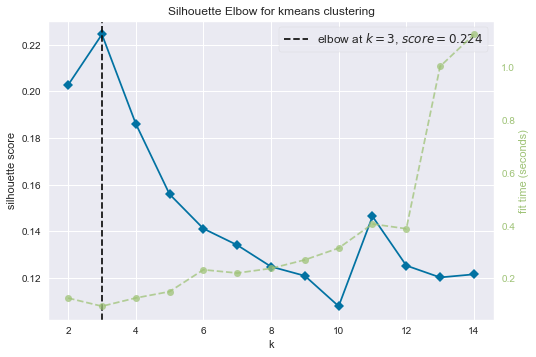

<AxesSubplot:title={'center':'Silhouette Elbow for kmeans clustering'}, xlabel='k', ylabel='silhouette score'>

In [124]:
km = KMeans(random_state=42, init='k-means++')
visualizer = KElbowVisualizer(km, k=(2, 15), 
                              metric='silhouette', 
                              title="Silhouette Elbow for kmeans clustering")
visualizer.fit(df_normalized)
visualizer.show()

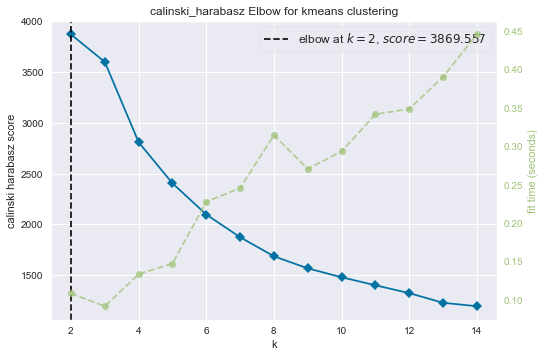

<AxesSubplot:title={'center':'calinski_harabasz Elbow for kmeans clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [183]:
km = KMeans(random_state=42, init='k-means++')
visualizer = KElbowVisualizer(km, k=(2, 15), 
                              metric='calinski_harabasz', 
                              title="calinski_harabasz Elbow for kmeans clustering")
visualizer.fit(df_normalized)
visualizer.show()

In [ ]:
kmeans = KMeans()
kmeans_param_grid = {
    'n_clusters': [2, 3],
    'init': ['k-means++', 'random'],
    'max_iter': [100, 300, 500],
    'random_state': [0, 42, 100]
}
kmeans_grid_search = GridSearchCV(kmeans, kmeans_param_grid, scoring=silhouette_score, cv=10)
kmeans_grid_search.fit(df_normalized)
best_kmeans = kmeans_grid_search.best_estimator_
best_kmeans_score = kmeans_grid_search.best_score_

In [191]:
best_kmeans

KMeans(max_iter=100, n_clusters=2, random_state=0)

In [325]:
kmeans = best_kmeans.fit(df_normalized)
df_km = kmeans.predict(df_normalized)

In [326]:
df_tsne['km'] = df_km

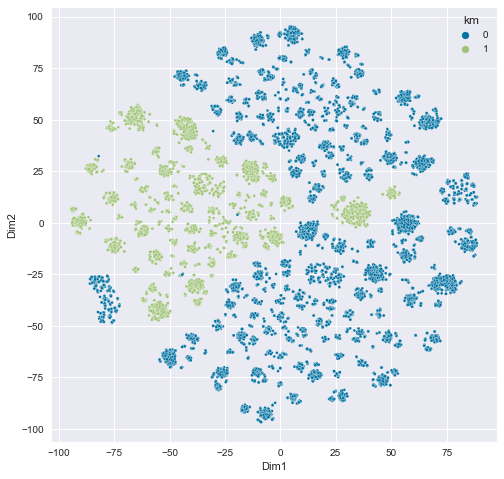

In [327]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_tsne, hue='km', x='Dim1', y='Dim2', s = 8)
plt.show()

In [328]:
ari_score = adjusted_rand_score(df_['FraudFound'], df_km)
ari_score

-0.04144517611185972

In [329]:
silhouette_score(df_normalized, df_km)

0.2034486053360196

In [330]:
davies_bouldin_score(df_normalized, df_km)

1.7845691861029598

### DBSCAN

In [198]:
dbscan = DBSCAN()
dbscan_param_grid = {
    'eps': [0.5, 1.0, 1.5],
    'min_samples': [3, 5, 7],
    'metric': ['euclidean', 'manhattan']
}
dbscan_grid_search = GridSearchCV(dbscan, dbscan_param_grid, scoring='adjusted_rand_score', cv=10)
dbscan_grid_search.fit(df_normalized)
best_dbscan = dbscan_grid_search.best_estimator_
best_dbscan_score = dbscan_grid_search.best_score_


In [406]:
best_dbscan = DBSCAN(min_samples=3, eps=2)

In [407]:
df_db = best_dbscan.fit_predict(df_normalized)
# df_db = best_dbscan.fit_predict(df_.drop('FraudFound', axis =1))

In [408]:
df_tsne['db'] = df_db

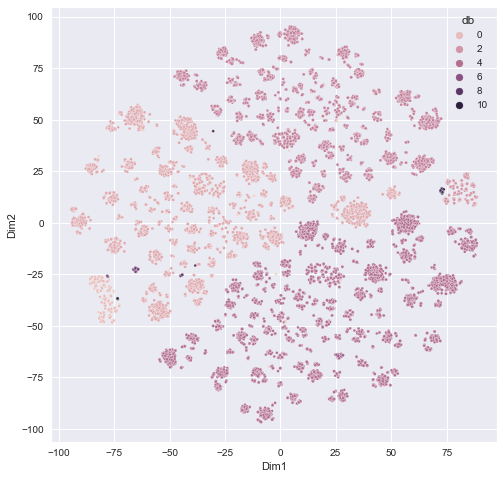

In [409]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_tsne, hue='db', x='Dim1', y='Dim2', s = 8)
plt.show()

In [410]:
ari_score = adjusted_rand_score(df_['FraudFound'], df_db)
ari_score

0.009665053422731914

In [411]:
db_dict = df_tsne['db'].value_counts().to_dict()

In [412]:
ranked_clusters = []
for key in db_dict.keys():
    if db_dict[key] > 100:
        ranked_clusters.append(key)

<AxesSubplot:xlabel='db', ylabel='count'>

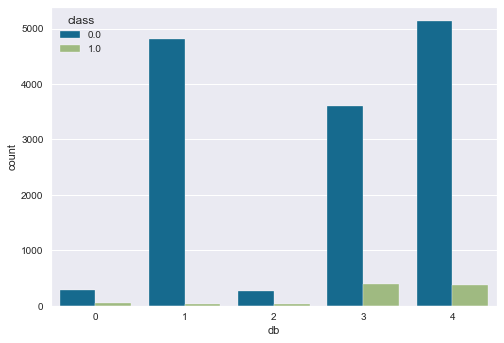

In [413]:
sns.countplot(data= df_tsne[df_tsne['db'].isin( ranked_clusters)], x='db', hue='class')

In [414]:
silhouette_score(df_normalized, df_db)

0.18349085616611327

In [415]:
davies_bouldin_score(df_normalized, df_km)

1.7845691861029598

### Isolation Forest

In [ ]:
isolation_forest = IsolationForest()
isolation_forest_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_samples': [100, 200, 300],
    'contamination': [0.1, 0.2, 0.3]
}
isolation_forest_grid_search = GridSearchCV(isolation_forest, isolation_forest_param_grid,
                                           scoring='average_precision', cv=10)
isolation_forest_grid_search.fit(df_normalized)
best_isolation_forest = isolation_forest_grid_search.best_estimator_
best_isolation_forest_score = isolation_forest_grid_search.best_score_

In [211]:
best_isolation_forest

IsolationForest(contamination=0.1, max_samples=100)

In [344]:
df_iforest = best_isolation_forest.fit_predict(df_normalized)

In [345]:
df_tsne['iforest'] = df_iforest

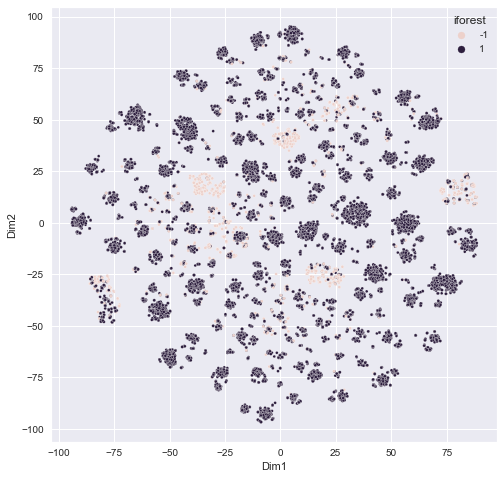

In [346]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_tsne, hue='iforest', x='Dim1', y='Dim2', s = 8)
plt.show()

In [347]:
ari_score = adjusted_rand_score(df_['FraudFound'], df_iforest)
ari_score

-0.003876237953657119

In [348]:
silhouette_score(df_normalized, df_iforest)

0.11943171954255578

In [349]:
davies_bouldin_score(df_normalized, df_iforest)

4.634552749893522

## Dimension Reduction

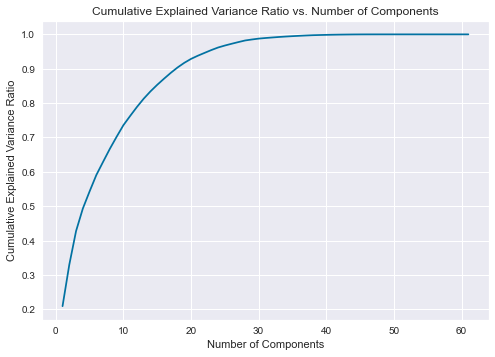

In [220]:
pca = PCA()
pca.fit(df_normalized)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

In [350]:
pca = PCA(n_components=30)
df_pca = pca.fit_transform(df_normalized)

In [351]:
df_pca_km = best_kmeans.fit_predict(df_pca)
silhouette_score(df_normalized, df_pca_km), \
davies_bouldin_score(df_normalized, df_pca_km), \
adjusted_rand_score(df_['FraudFound'], df_pca_km)

(0.2034486053360196, 1.7845691861029598, -0.04144517611185972)

In [416]:
df_pca_db = best_dbscan.fit_predict(df_pca)
silhouette_score(df_normalized, df_pca_db), \
davies_bouldin_score(df_normalized, df_pca_db), \
adjusted_rand_score(df_['FraudFound'], df_pca_db)

(0.16783461536572045, 2.432940287696945, -0.0021934956034031536)

In [ ]:
df_pca_if = best_isolation_forest.fit_predict(df_pca)
silhouette_score(df_normalized, df_pca_if), \
davies_bouldin_score(df_normalized, df_pca_if), \
adjusted_rand_score(df_['FraudFound'], df_pca_if)

(0.09234365245961756, 6.601692111154475, 0.03117875223758775)

In [418]:
var_threshold = VarianceThreshold(threshold=0.2)
X_selected = var_threshold.fit_transform(df_normalized)

In [401]:
X_selected.shape

(15100, 11)

In [ ]:
df_selected_km = best_kmeans.fit_predict(X_selected)
silhouette_score(df_normalized, df_selected_km), \
davies_bouldin_score(df_normalized, df_selected_km), \
adjusted_rand_score(df_['FraudFound'], df_selected_km)

(0.202727114456357, 1.790836735690526, -0.04148290683166717)

In [ ]:
df_selected_db = best_dbscan.fit_predict(X_selected)
silhouette_score(df_normalized, df_selected_db), \
davies_bouldin_score(df_normalized, df_selected_db),\
adjusted_rand_score(df_['FraudFound'], df_selected_db)

In [ ]:
df_selected_if = best_isolation_forest.fit_predict(X_selected)
silhouette_score(df_normalized, df_selected_if), \
davies_bouldin_score(df_normalized, df_selected_if),\
adjusted_rand_score(df_['FraudFound'], df_selected_if)

(0.05688478602321511, 4.486719080432971, 0.03294077737370337)